In [286]:
#!pip install fuzzy-c-means
#!pip install scikit-fuzzy

In [338]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import scatterplot as scatter
import scipy as sc
import matplotlib.pyplot as plt
from scipy.spatial import distance
import math
from sklearn.metrics import confusion_matrix
from sklearn . decomposition import PCA
import pdb
from fcmeans import FCM
import skfuzzy as fuzz
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Loading data

In [340]:
#data processing:

def loadData(filePath):
    dataRaw = []
    labelsRaw = []
    DataFile = open(filePath)

    while True:
        theline = DataFile.readline()

        if len(theline) == 0:
            break

        theline = theline.rstrip()

        readData = theline.split(",")
        #appending variables
        for pos in range(len(readData)-1):
            readData[pos] = (readData[pos]);

            #labelsRaw.append(float(readData[-1])
        dataRaw.append(readData[0:8])
        
        #appending target variables
        labelsRaw.append(float(readData[-1]))
       

                
    DataFile.close()
    data = np.array(dataRaw)
    labels = np.array(labelsRaw)

    return data, labels

def standard(data): 
    standardData = data .copy()

    rows = data.shape[0]
    cols = data.shape[1]

    for j in range(cols):
        sigma = np.std(data[:,j])
        mu = np. mean(data[:,j])
        
        for i in range(rows):
            standardData[i,j] = (data[i,j] - mu)/sigma

    return standardData


def normalise(data):
    normalisedData = data.copy()


    rows = data.shape[0]
    cols = data.shape[1]

    for j in range (cols):
        maxElement = np.amax(data[:,j])
        minElement = np.amin(data[:,j])

        for i in range(rows):
            normalisedData[i,j] = (data[i,j] - minElement)/(maxElement - minElement)

    return normalisedData


#K-means

"""
def dist(u,v,VI=VI):
    #IV is inverse of the covariance matrix.
    #cov = np.cov(data.values.T)  
    #IV = np.linalg.inv(cov)
    delta = u - v
    m = np.dot(np.dot(delta,VI), delta.transpose())
    
    return np.sqrt(m)
"""

def dist(p1 , p2):
    sumTotal = 0

    for c in range (len(p1)):
        sumTotal = sumTotal + pow (( p1[c] - p2[c]) ,2)

    return math.sqrt(sumTotal)

def minDistPos(point, matrix):
    minPos = -1
    minValue = float("inf")

    for rowPos in range(len(matrix)):
        d = dist(point , matrix [rowPos ,:])

        if (d < minValue ):
            minValue = d
            minPos = rowPos

    return minPos

def sumDist (m1 , m2):
    sumTotal = 0

    for pos in range(len(m1)):
        sumTotal = sumTotal + dist(m1[pos ,:] , m2[pos ,:])

    return sumTotal

def kmeans(standardisedData,columns, k=2, threshold=0.05):
    # Initial centroids
    C = np.random.random((k, columns))
    
    # scale the random numbers
    for f in range (columns):
        maxValue = standardisedData[:,f].max()
        minValue = standardisedData[:,f].min()

        for c in range (k):
            C[c,f] = minValue + C[c,f] * ( maxValue - minValue )

    #default old centroid :(0,0)
    C_old = np.zeros(C.shape)

    #create an array with size same as data
    clusters = np.zeros(len(standardisedData))

    distCentroids = float ("inf")

    C = np. random.random((k, columns))

    #finding centroids
    while distCentroids > threshold :

        # loop through all rows
        for i in range(len(standardisedData)):

            #equivalent to return nearest centroid position : which cluster does it belong to
            clusters[i]= minDistPos(standardisedData[i],C)

        #update new centroid
        C_old = C.copy()
        
        for i in range(k):
            
            points = np.array([])

            for j in range(len(data)):

                #if this data point is in i group
                if (clusters[j] == i):

                    if (len(points) == 0): 
                        points = standardisedData[j ,:].copy()
                    else :
                        # add actual value to point i array
                        points = np.vstack((points, standardisedData[j ,:]))

            # new centroid is the mean of all points in its group            
            C[i] = np. mean(points, axis =0)

        #calculate the sum of distance that centroid move
        distCentroids = sumDist(C, C_old)
        
    #calculating distortion
    SSE = 0
    #go through every data point
    for j in range(len(data)):
        #if this data point is in i group
        rowPos = int(clusters[j])
        SSE += pow(dist(standardisedData[j ,:],C[ rowPos,:]),2)
        
    #print(SSE)        
    return C, clusters, SSE


#PCA

def orderEigenVectors(eigVectors,eigVals):

    orderedEigVectors = np.empty(eigVectors.shape)
    tmp = eigVals.copy()
    maxValue = float ("-inf")
    maxValuePos = -1
    
    for i in range(len(eigVectors)):

        maxValue = float ("-inf")
        maxValuePos = -1

        for n in range (len(eigVectors)):
            if (tmp [n] > maxValue):
                maxValue = tmp[n]
                maxValuePos = n

            orderedEigVectors[:,i] = eigVectors [:, maxValuePos]
            tmp [maxValuePos] = float ("-inf")
    
    return orderedEigVectors

# accuracy
def accuracy(labels, clusters):

    tn, fp, fn, tp = confusion_matrix(labels, clusters).ravel()
    accuray    = (tn+tp)/(tn+ fp +fn +tp)
    precision  = tp/(tp+fp) 
    recall     = tp/(tp+fn)
    f1         = (2*(precision*recall))/(precision+recall)

    return(accuray ,precision, recall , f1)

def sort(nlist):
    for passnum in range(len(nlist)-1,0,-1):
        for i in range(passnum):
            if nlist[i]<nlist[i+1]:
                temp = nlist[i]
                nlist[i] = nlist[i+1]
                nlist[i+1] = temp
    return nlist


#DBSCAN: k-dist graph

def kn_distance(data,k):

    kn_distance = []
    for i in range(len(data)):
        eucl_dist = []
        for j in range(len(data)):
            eucl_dist.append(dist(data[i,:],data[j,:]))

        eucl_dist.sort()
        kn_distance.append(eucl_dist[k])

    return kn_distance

In [256]:
data, labels = loadData("HTRU_2.csv")
standardisedData = standard(data)
#print(data)
print(labels)

[0. 0. 0. ... 0. 0. 0.]


# Visualizing Data

//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


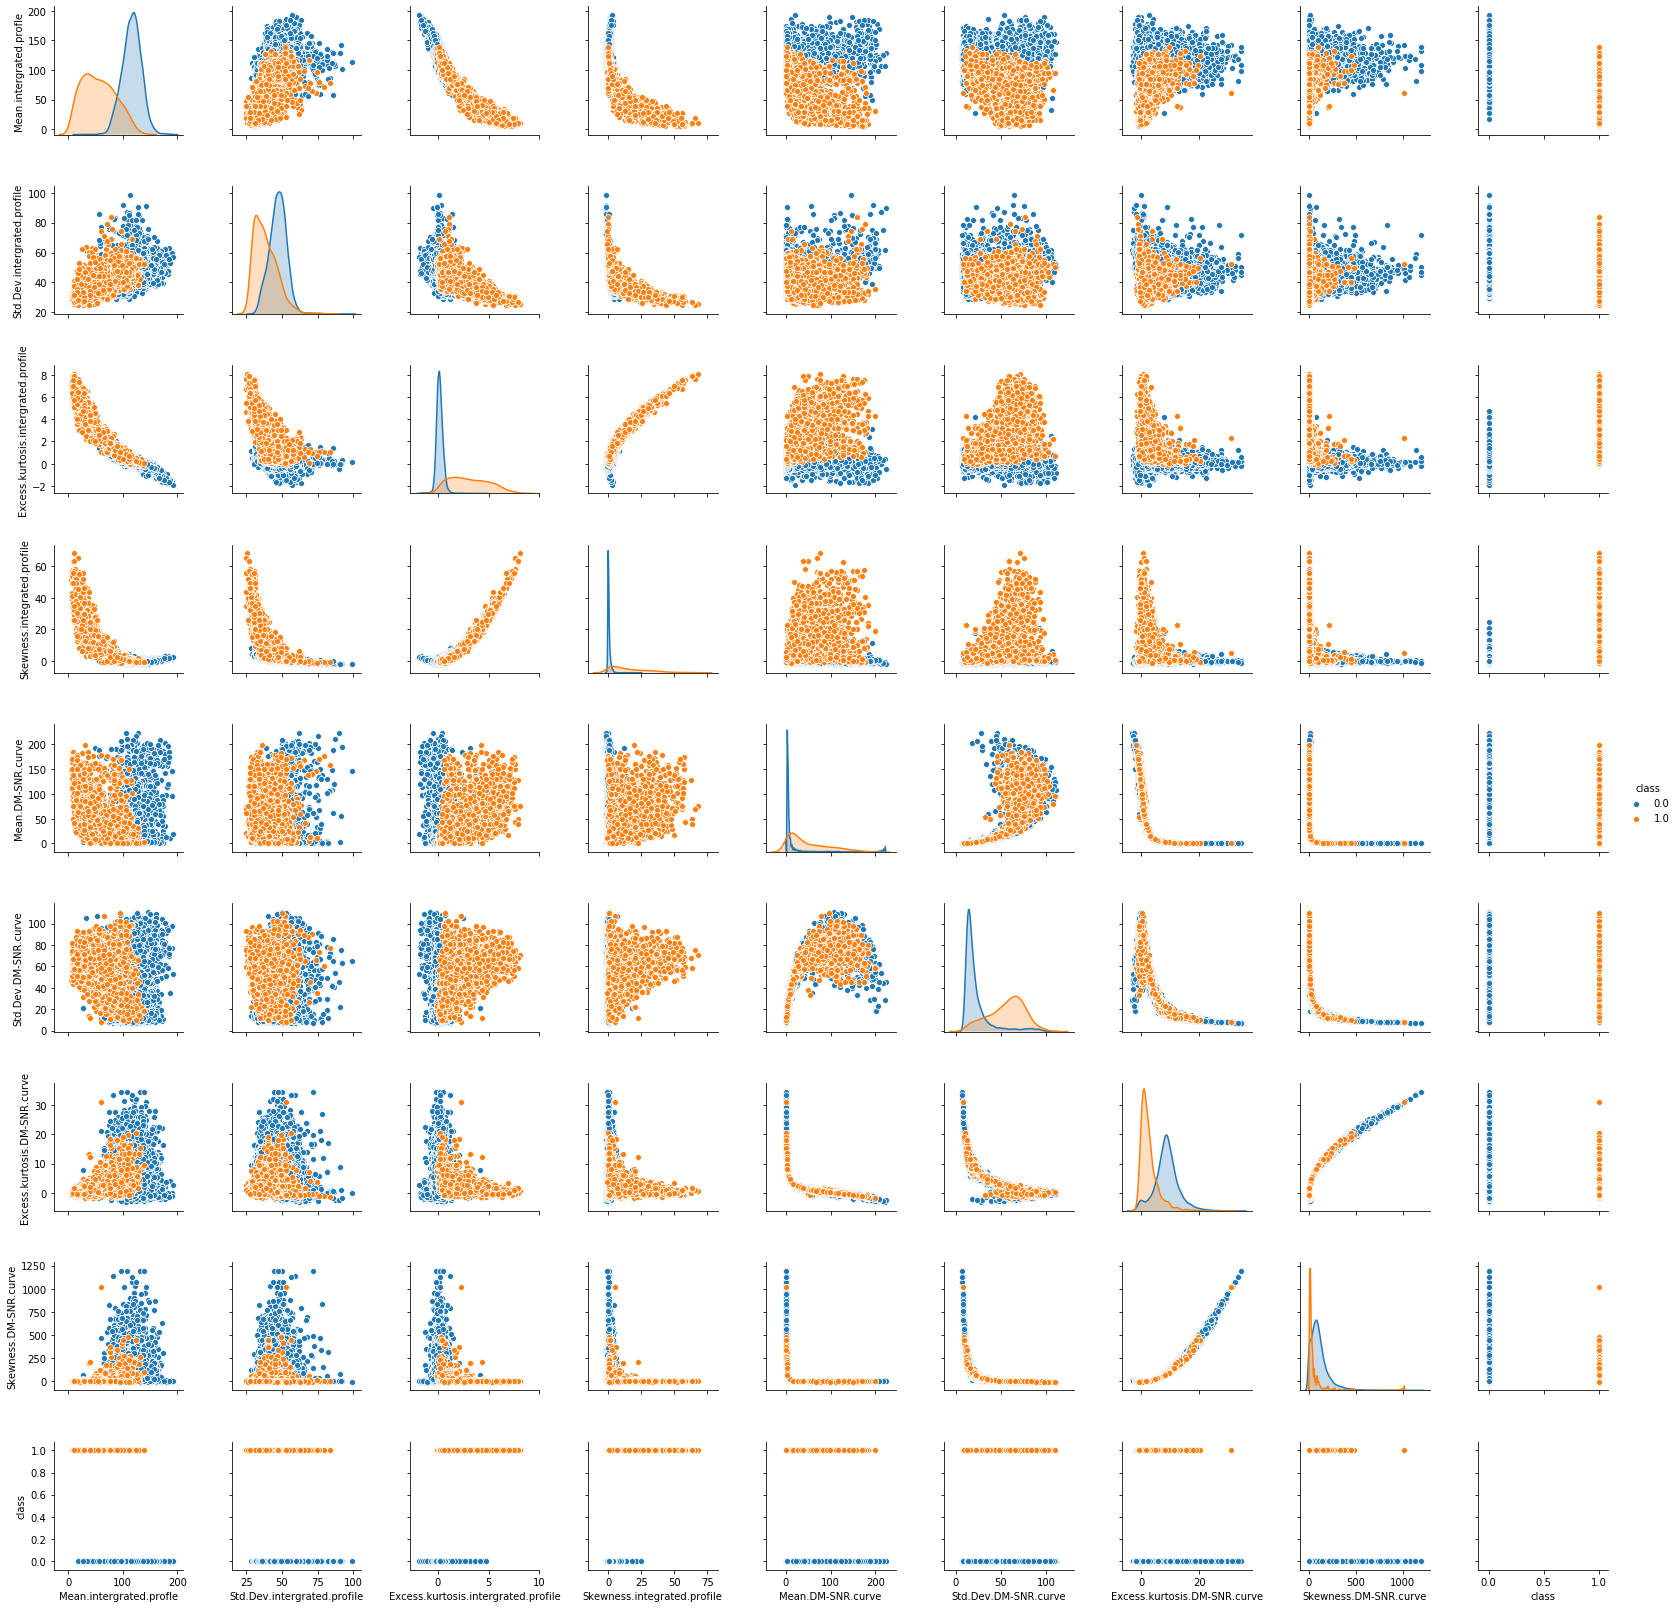

In [34]:
df_data = pd.DataFrame(data, columns = ['Mean.intergrated.profle'
                                 , 'Std.Dev.intergrated.profile'
                                 , 'Excess.kurtosis.intergrated.profile'
                                 , 'Skewness.integrated.profile'
                                 , 'Mean.DM-SNR.curve'
                                 , 'Std.Dev.DM-SNR.curve'
                                 , 'Excess.kurtosis.DM-SNR.curve'
                                 , 'Skewness.DM-SNR.curve'])

df_labels = pd.DataFrame(labels,columns=["class"])

df  = pd.concat([df_data, df_labels], axis=1, sort=False)
sns.pairplot(df,hue = "class")
plt.show()
#plt.savefig("actual_cluster.png")
plt.close() 

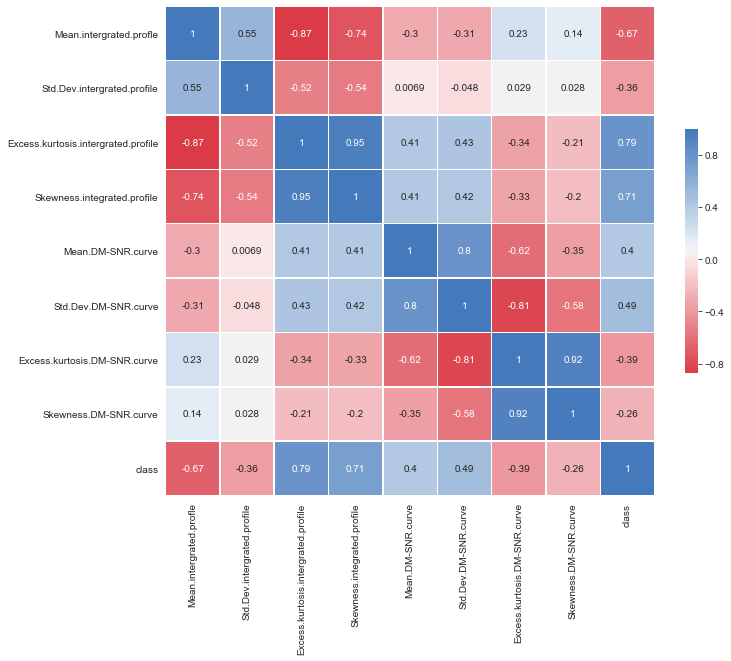

In [17]:
# Compute correlations
corr = df.corr()

# Set background color / chart style
sns.set_style(style = 'white')

# Set up  matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Add diverging colormap
cmap = sns.diverging_palette(10, 250, as_cmap=True)

# Draw correlation plot
sns.heatmap(corr, cmap=cmap, 
        square=True,
        linewidths=.5
        ,cbar_kws={"shrink": .5}
        ,ax=ax
        ,annot=True)


It is highly correlated in both intergrated profile and DM-SNR. Especially between mean and excess kurtois/ skewness of intergrated profile, and between standard deviation and excess kurtois/ skewness. It is because .......(explain the formula).The problem to this is.....(Problem?). The solution to this is to .....(PCA?)

https://stats.stackexchange.com/questions/62253/do-i-need-to-drop-variables-that-are-correlated-collinear-before-running-kmeans
It's advisable to remove variables if they are highly correlated.
Irrespective of the clustering algorithm or linkage method, one thing that you generally follow is to find the distance between points. Keeping variables which are highly correlated is all but giving them more, double the weight in computing the distance between two points(As all the variables are normalised the effect will usually be double).

https://www.researchgate.net/post/Which_clustering_method_is_best_for_highly_correlated_data
If you have a correlated data you should use a distance metric that use the correlation for measuring similarity.
The distance measure that uses correlation explicitly is Mahalanobis distance 

Using k-means clustering that uses Pearson correlation as the similarity metric worked best for me. MATLAB has the implementation for k-means clustering with Pearson correlation similarity metric. 

High Correlation is very subjective and please bear in mind that it will only indicate linear relationship. As suggested by Amitay a good option may be use Mahalnabis distance for calculating the dissimilarity matrix and then apply K means or Fuzzy C means. 


https://www.greenbook.org/marketing-research/cluster-analysis
However, collinearity can become a major problem when such distance based measures are used. It poses a serious problem that, unless addressed, can produce distorted results. When two independent variables are highly correlated, it becomes difficult to accurately partial out their individual impact on the dependent variable. When variables used in clustering are collinear, some variables get a higher weight than others. If two variables are perfectly correlated, they effectively represent the same concept. But that concept is now represented twice in the data and hence gets twice the weight of all the other variables. The final solution is likely to be skewed in the direction of that concept, which could be a problem if it’s not anticipated. In the case of multiple variables and multicollinearity, the analysis is in effect being conducted on some unknown number of concepts that are a subset of the actual number of variables being used in the analysis.


# Clustering (euclidean)

# determing K : distortion(SSE)

Distortion: It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.
Inertia: It is the sum of squared distances of samples to their closest cluster center.

[143183.99999999965, 92214.76023984289, 68075.2377757768, 53125.00456238107, 44223.24207797187]


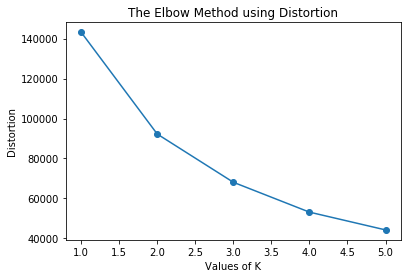

In [143]:
distortions=[]
K = list(range(1, 6, 1))
for i in K:
    distortions.append(kmeans(standardisedData,8,i)[2])

print(distortions)


plt.plot(K, distortions, 'o-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()  

In [146]:
#np.random.seed(101)
C, clusters,distortion = kmeans(standardisedData,8)
print(accuracy(labels,clusters))

(0.9371438149513912, 0.6256109481915934, 0.7809640024405126, 0.6947082767978291)


In [145]:
# plotting
df_clusters = pd.DataFrame(clusters,columns=["clusters"])

df  = pd.concat([df_data, df_clusters], axis=1, sort=False)
sns.pairplot(df,hue = "clusters")
plt.show()
plt.savefig ("predicted_cluster.png")
plt.close()           

NameError: name 'df_data' is not defined

# Clustering Validation

In [ ]:
#visualization

# Plot the clustered data
fig, ax = plt.subplots(figsize=(6, 6))

plt.scatter(clusters[km.labels == 0, 0], X_std[km.labels == 0, 1],
            c='green', label='cluster 1')
plt.scatter(X_std[km.labels == 1, 0], X_std[km.labels == 1, 1],
            c='blue', label='cluster 2')
plt.scatter(C[:, 0], C[:, 1], marker='*', s=300,
            c='r', label='centroid')
plt.legend()

plt.xlim([-10, 10])
plt.ylim([-10, 10])

#plt.xlabel('Eruption time in mins')
#plt.ylabel('Waiting time to next eruption')
#plt.title('Visualization of clustered data', fontweight='bold')
#ax.set_aspect('equal');

# PCA

[0.51675584 0.26807564 0.10116862 0.0571781  0.03227836 0.01998491
 0.00255524 0.00200328]


Text(0, 0.5, '2nd Principal Component')

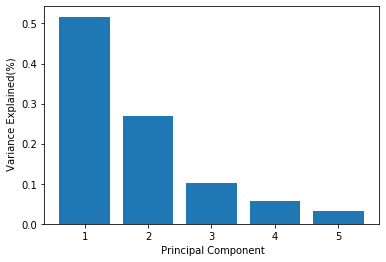

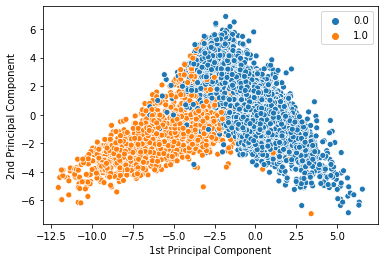

In [433]:
#creating covariance matrix and finding eigencetors, eigenvalues
cov = np.cov(standardisedData.transpose())
eigVals , eigVectors = sc.linalg.eig(cov)
orderedEigVector = orderEigenVectors(eigVectors,eigVals)

# pca variance explained
sort_eigVals = sort(eigVals.real)
var_explained = np.array(sort_eigVals/sum(sort_eigVals))
print(var_explained)


plt.figure( figsize =(6 ,4))
plt.bar ([1 ,2 ,3 ,4 ,5] ,var_explained[0:5], tick_label =[1 ,2 ,3 ,4 ,5])
plt.xlabel (" Principal Component")
plt.ylabel (" Variance Explained(%)")
#plt.savefig (" PCAAnalysis .pdf")

plt.figure (figsize =(6 ,4))
scatter(PCAdata[:,0], PCAdata[:,1], hue=labels)
plt.xlabel ("1st Principal Component")
plt.ylabel ("2nd Principal Component")



In [148]:
# pca transformation: pcs = 2
k = 2
projectionMatrix = orderedEigVector[: ,0:k]
pcaByHandData = standardisedData.dot(projectionMatrix)
PCAdata = pcaByHandData[:,:2]

[112375.30993840925, 63135.01480293814, 39558.180480650684, 29121.45960060923, 23717.650093339835]


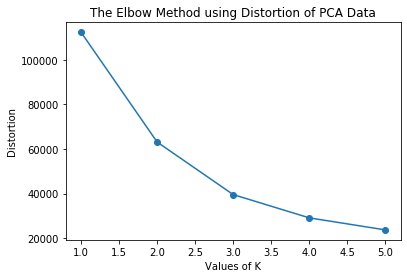

In [149]:
distortions=[]
K = list(range(1, 6, 1))
for i in K:
    distortions.append(kmeans(PCAdata,2,i)[2])
print(distortions)
plt.plot(K, distortions, 'o-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion of PCA Data') 
plt.show()  

(0.9407755056430886, 0.6407389402041809, 0.8041488712629652, 0.7132034632034632)


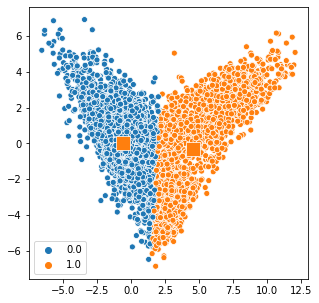

In [531]:
# pca data k-means clustering outcome
C_pca1, clusters_pca1,distortion = kmeans(PCAdata,2)
print(accuracy(labels, clusters_pca1))

# plot result
plt.figure(figsize=(5,5))
scatter(PCAdata[:,0], PCAdata[:,1], hue=clusters_pca1)
scatter(C_pca1[:,0], C_pca1[:,1],marker="s",s=200)
plt.show()


# PCA using scikit-learn library

Text(0, 0.5, '2nd Principal Component ')

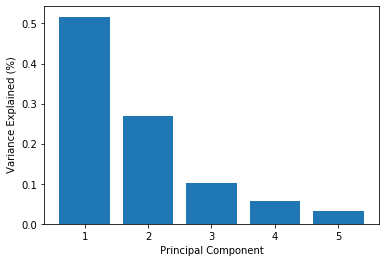

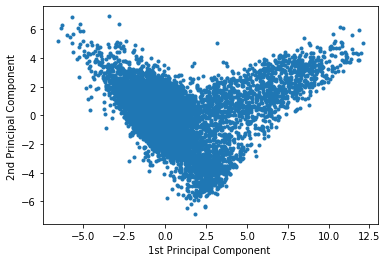

In [45]:
pca = PCA (n_components =5)
pca.fit(standardisedData)
Coeff = pca. components_
transformedData = pca.transform(standardisedData)

plt.figure( figsize =(6 ,4))
plt.bar ([1 ,2 ,3 ,4 ,5] ,pca.explained_variance_ratio_ , tick_label =[1 ,2 ,3 ,4 ,5])
plt.xlabel (" Principal Component ")
plt.ylabel (" Variance Explained (%)")
#plt.savefig (" PCAAnalysis .pdf")

plt.figure (figsize =(6 ,4))
plt.plot(transformedData [: ,0] , transformedData [: ,1] ,".")
plt.xlabel ("1st Principal Component")
plt.ylabel ("2nd Principal Component")
#plt . savefig (" PCAData .pdf")

In [529]:
#clustering
pca = PCA (n_components =5)
pca.fit (standardisedData)
Coeff = pca.components_
transformedData = pca.transform(standardisedData)
PCAdata = transformedData[:,:2]
C_pca, clusters_pca.distortion = kmeans(PCAdata,2)
print(accuracy(labels, clusters_pca))

# plot result
plt.figure(figsize=(5,5))
scatter(PCAdata[:,0], PCAdata[:,1], hue=clusters_pca)
scatter(C_pca[:,0], C_pca[:,1],marker="s",s=200)
plt.show()


ValueError: too many values to unpack (expected 2)

# Clustering : silhouette value

# Fuzzy c means : skyfuzzy library

In [341]:
#data prepatation
PC1 = PCAdata[:,0] # first column
PC2 = PCAdata[:,1] #

allData = np.vstack((PC1,PC2))

# skyfuzzy library
ncenters = 2
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(allData, c=ncenters, m=1.5, error=0.005, maxiter=200, init=None)
cluster_membership = np.argmax(u, axis=0)

print(accuracy(labels, cluster_membership))

(0.9626773941222483, 0.8217362491716369, 0.7565588773642465, 0.7878017789072428)


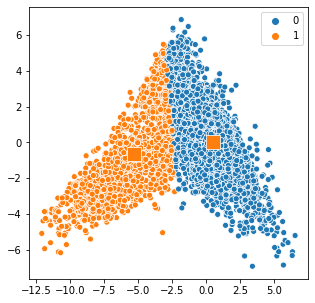

In [312]:
# plot result
plt.figure(figsize=(5,5))
scatter(PCAdata[:,0], PCAdata[:,1], hue=fcm_labels)
scatter(cntr[:,0], cntr[:,1],marker="s",s=200)
plt.show()

# DBscan: determing epsilon

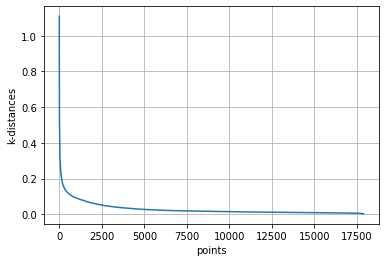

In [475]:

PCAdata_scaled = standard(PCAdata)

#knn_distance = kn_distance(PCAdata_scaled, 3)
knn_distance_flat=(np.array(knn_distance)).flatten()
plt.plot(sort(knn_distance_flat))
plt.ylabel("k-distances")
plt.xlabel("points")
plt.grid(True)
plt.show()
#15min

#np.savetxt("knn_distance_scaled_flat_1214.csv", knn_distance_flat, delimiter=",")

In [523]:
# cluster the data 
dbscan = DBSCAN(eps=0.25, min_samples =55)
dbscan_clusters = dbscan.fit_predict(X_scaled)
print(dbscan_clusters)
#print(accuracy(labels, dbscan_clusters))

[ 0  0  0 ...  0  0 -1]


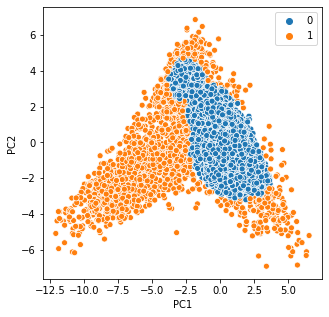

In [527]:
# plot result
plt.figure(figsize=(5,5))
scatter(PCAdata[:,0], PCAdata[:,1], hue=dbscan_clusters)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [524]:
print(dbscan_clusters)
unique_elements, counts_elements = np.unique(dbscan_clusters, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[ 0  0  0 ...  0  0 -1]
[[   -1     0]
 [ 1795 16103]]


In [525]:
#relabeling
for i in range(len(dbscan_clusters)):
    if dbscan_clusters[i] ==-1:
        dbscan_clusters[i] =1
    else:
        dbscan_clusters[i] =0

In [526]:
print(accuracy(labels, dbscan_clusters))

(0.9503855179349648, 0.7091922005571031, 0.776693105552166, 0.7414094350611532)


# Clustering Quality Comparison

In [ ]:
"""
Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626
"""